In [1]:
import requests as r 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import csv
import json
from tensorflow import keras

2021-10-22 23:50:51.308178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-22 23:50:51.308220: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df=pd.read_csv('/home/edugonik/Documents/git/tp_curso_ml/src/pickle/datasets/extract.tab', sep = '\t')
df.columns

Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Gene names',
       'Organism', 'Length', 'Binding site', 'Function [CC]', 'Metal binding',
       'Nucleotide binding', 'Site', 'Annotation', 'Gene names  (ORF )',
       'Sequence', 'Developmental stage', 'Tissue specificity',
       'Gene ontology (molecular function)',
       'Gene ontology (cellular component)', 'Coiled coil',
       'Compositional bias', 'Protein families', 'Organism ID',
       'Gene ontology IDs', 'Intramembrane', 'Subcellular location [CC]',
       'Topological domain', 'Transmembrane'],
      dtype='object')

In [3]:
transmembrana = df.dropna(subset=['Transmembrane'])

In [4]:
def random_selection_dataframe(dataframe: pd.DataFrame, length:int)-> pd.DataFrame:
    dataframe.reset_index(drop=True, inplace=True)
    selected_indeces=np.random.choice(a=dataframe.index, size=length, replace=False)
    return dataframe.iloc[selected_indeces,:]

In [5]:
n_residuos_tm=lambda row:len(re.findall(r"(TRANSMEM \d+(..)\d+;)",row['Transmembrane']))
n_residuos_tm_np=np.vectorize(lambda datum:len(re.findall(r"(TRANSMEM \d+(..)\d+;)",datum)))

In [6]:
set_todos=set(df.Entry)
set_transmembrana=set(transmembrana.Entry)

In [7]:
set_no_transmembrana=set_todos - set_transmembrana
no_transmembrana=df[df.Entry.isin(set_no_transmembrana)]

In [8]:
sel_nt=random_selection_dataframe(no_transmembrana[['Sequence','Transmembrane']], transmembrana.shape[0]).to_numpy()
sel_t=transmembrana[['Sequence', 'Transmembrane']].to_numpy()
sel_t[:,1]=n_residuos_tm_np(sel_t[:,1])
sel_nt[:,1]=0

# label=np.vstack([np.ones((sel_t.shape[0],1)), np.zeros((sel_nt.shape[0],1))])
data=np.vstack([sel_t,sel_nt])
data.shape

(157710, 2)

In [9]:
allchars=set()
for n,node in enumerate(data[:,0]):
        for char in node:
            allchars.add(char)

In [23]:
codigo_numerico={}
for n,char in enumerate(allchars,1):
    codigo_numerico[char]=n
with open('codigo_numerico.json', 'w') as file:
    json.dump(codigo_numerico, file)

[]

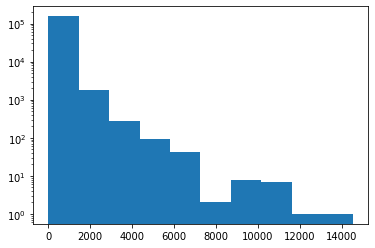

In [11]:
plt.hist(np.vectorize(len)(data[:,0]))
plt.semilogy()

In [12]:
data=data[np.vectorize(len)(data[:,0]) < 2000] #Solo incluyo secuencias menores a 2000 pb

In [39]:
numeric_nodes=[]
for node in data[:,0]:
    numeric_nodes.append(keras.preprocessing.sequence.pad_sequences(np.array([codigo_numerico[char] for char in node], dtype=int).reshape(1,-1), 2000))
seqs=np.vstack(numeric_nodes)

array(['0', '0', '0', ..., '0', '0', '2'], dtype='<U18562')

array([[ 0,  0,  0, ...,  9, 21,  0],
       [ 0,  0,  0, ...,  2,  8,  0],
       [ 0,  0,  0, ..., 22, 24,  0],
       ...,
       [ 0,  0,  0, ..., 24, 24,  0],
       [ 0,  0,  0, ..., 19, 22,  0],
       [ 0,  0,  0, ..., 10, 11,  2]])

In [34]:
seqs.shape, data[:,1].shape

((61630, 2000), (61630,))

In [14]:
np.savez_compressed('/home/edugonik/Documents/git/tp_curso_ml/src/pickle/numpy_arrays/data_compressed.npz', seqs=seqs, labels_tmd=labels_tmd, labels_ntmd=labels_ntmd)

In [15]:
go_proteins={}
for (ni, entry),(n,row) in zip(transmembrana['Entry'].iteritems(),transmembrana["Gene ontology (cellular component)"].iteritems()):
    if not pd.isna(row):
        go_proteins[entry]=row.split(';')
    else:
        pass

In [16]:
plasma_membrane={}
for protein, go_terms in go_proteins.items():
    for go_term in go_terms:
        qry=re.findall(r"GO:0005886", go_term)
        if qry:
            plasma_membrane[protein]=go_terms
            

In [17]:
go_terms={
    "mitochondria":"GO:0031966",
    "nuclear":'GO:0031965',
    "cell":'GO:0005886'
}

In [65]:
data_raw=[]
classes={
    0:[],
    1:[],
    2:[]
}
for i, node in df.iterrows():
    try:
        if len(node.Sequence) < 2000:
            if go_terms['cell'] in node['Gene ontology (cellular component)']:
                data_raw.append([node.Sequence, 0])
                classes[0].append(node.Sequence)
            elif go_terms['mitochondria'] in node['Gene ontology (cellular component)']:
                data_raw.append([node.Sequence,1])
                classes[1].append(node.Sequence)

            elif go_terms['nuclear'] in node["Gene ontology (cellular component)"]:
                data_raw.append([node.Sequence,2])
                classes[2].append(node.Sequence)

        
    except TypeError:
        pass
    


In [72]:
seq_minima=min([len(value) for value in classes.values()])
secuencias=[]
for n,value in enumerate(classes.values()):
    sel=np.random.choice(value, seq_minima, replace=False).reshape(-1,1)
    secuencias.append(np.hstack([sel,np.full(sel.shape, n )]))
data_raw=np.vstack(secuencias)

In [75]:
data_raw_np=np.array(data_raw )
# data=data_raw_np[np.where(np.vectorize(len)(data_raw_np[:,0]) < 2000)[0]]
data=data_raw
numeric_nodes=[]
for node in data[:,0]:
    numeric_nodes.append(keras.preprocessing.sequence.pad_sequences(np.array([codigo_numerico[char] for char in node], dtype=int).reshape(1,-1), 2000))
seqs=np.vstack(numeric_nodes)
final_data=np.hstack([seqs, data[:,1].astype(int).reshape(-1,1)])


In [78]:
np.save('/home/edugonik/Documents/git/tp_curso_ml/src/pickle/numpy_arrays/data', final_data)